### Project work for course Social Data Analysis and Visualization of the DTU.

Required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
import folium
from folium.plugins import HeatMap
from folium import plugins

#### Reading data files and saving to pandas
For collecting the data, various data-sources from Kaggle were used.

In [2]:
df = pd.read_csv('covid_19_clean_complete.csv', parse_dates = ['Date']).sort_values(by=['Date'],ascending = False)
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
25151,NaN,Yemen,15.552727,48.516388,2020-04-26,1,0,0
24987,NaN,Ecuador,-1.831200,-78.183400,2020-04-26,22719,576,1366
24985,NaN,Djibouti,11.825100,42.590300,2020-04-26,1023,2,411
24984,NaN,Denmark,56.263900,9.501800,2020-04-26,8575,422,5805
24983,Greenland,Denmark,71.706900,-42.604300,2020-04-26,11,0,11


Checking the basic information of the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25152 entries, 25151 to 0
Data columns (total 8 columns):
Province/State    7680 non-null object
Country/Region    25152 non-null object
Lat               25152 non-null float64
Long              25152 non-null float64
Date              25152 non-null datetime64[ns]
Confirmed         25152 non-null int64
Deaths            25152 non-null int64
Recovered         25152 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.7+ MB


Checking for missing values in the dataframe:

In [4]:
df.isna().sum()

Province/State    17472
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

This result is normal as there is no distinctrion between different Provinces or States for most countries.

Next step, is reading the data for temperature and calculating the average temperature by country. This data will be used in the last part of the analysis.

In [70]:
global_temp_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
global_temp_country = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])].replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

#Calculating average temperature by country

countries = np.unique(global_temp_country['Country'])
mean_temp = np.unique(global_temp_country['Country'])
mean_temp = pd.DataFrame(data=mean_temp, columns=['Country'])
mean_temp1 = []
for country in countries:
    mean_temp1.append(global_temp_country[global_temp_country['Country'] == country]['AverageTemperature'].mean())
 
mean_temp1 = pd.DataFrame(data=mean_temp1, columns=['AverageTemperature'])
mean_temp = mean_temp.merge(mean_temp1, how='inner',left_index=True, right_index=True)

In [75]:
mean_temp.describe()

,AverageTemperature
count,235.000000
mean,18.834126
std,8.927252
min,-18.587458
25%,10.928409
50%,22.985112
75%,26.110151
max,28.816603


Checking the date of last update that is included in the dataset.

In [5]:
last_date = max(df['Date'])
last_date

Timestamp('2020-04-26 00:00:00')

#### Data Preprocessing 

###### Cleaning data

First of all creating a new column for the active COVID-19 incidents. 
<br>This column is calculated by subtracting the number of the Recovered patients and the number of the Deaths from the Confirmed patients.

In [6]:
df['Active'] = df['Confirmed'] - df['Recovered'] - df['Deaths']

Next step is to fill missing values in the dataframe.
<br> As checked before, the only column with missing values is the Province/State. The empty cells will be filled with just a space.
<br> However, in order to be sure that there are no discrepancies, a fillna(0) will be run for the columns Confirmed, Recovered, Deaths and Active.

In [7]:
df[['Province/State']] = df[['Province/State']].fillna('')
df[['Confirmed', 'Recovered', 'Deaths', 'Active']] = df[['Confirmed', 'Recovered', 'Deaths', 'Active']].fillna(0)

Checking the types of the data.

In [8]:
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
dtype: object

In [9]:
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
25151,,Yemen,15.552727,48.516388,2020-04-26,1,0,0,1
24987,,Ecuador,-1.831200,-78.183400,2020-04-26,22719,576,1366,20777
24985,,Djibouti,11.825100,42.590300,2020-04-26,1023,2,411,610
24984,,Denmark,56.263900,9.501800,2020-04-26,8575,422,5805,2348
24983,Greenland,Denmark,71.706900,-42.604300,2020-04-26,11,0,11,0


Next step for the preprocessing part is to create a new dataframe with the values of the original dataframe grouped by date and country.

In [27]:
df_date_country = df.groupby(['Date','Country/Region']).aggregate({'Lat': 'min',
                                                                   'Long': 'max',
                                                                   'Confirmed': 'sum',
                                                                   'Deaths': 'sum',
                                                                   'Active': 'sum',
                                                                   'Recovered': 'sum'}).reset_index()
df_date_country.head(5)

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Active,Recovered
0,2020-01-22,Afghanistan,33.0000,65.0000,0,0,0,0
1,2020-01-22,Albania,41.1533,20.1683,0,0,0,0
2,2020-01-22,Algeria,28.0339,1.6596,0,0,0,0
3,2020-01-22,Andorra,42.5063,1.5218,0,0,0,0
4,2020-01-22,Angola,-11.2027,17.8739,0,0,0,0


Calculating new cases and adding it as a new column in the grouped dataframe.

In [28]:
# Using the pandas.Dataframe.sum and pandas.DataFrame.diff, the differences between the total incidents for each date and for each country is calculated. 
new = df.groupby(['Date','Country/Region'])['Confirmed', 'Recovered', 'Deaths'].sum().diff().reset_index()
mask = new['Country/Region'] != new['Country/Region'].shift(1)
new.loc[mask, 'Confirmed'] = np.nan
new.loc[mask, 'Deaths'] = np.nan
new.loc[mask, 'Recovered'] = np.nan
new_columns = ['New cases','New recovered','New deaths']
new.columns = ['Date', 'Country/Region', 'New cases', 'New recovered', 'New deaths']
# Merging the two tables to get the full grouped table with the number of incidents and the number of new incidents per day per country
df_date_country = pd.merge(df_date_country, new, on = ['Date','Country/Region'])
#Lastly, as before, all na are filled with 0, the negative values are turned to 0 and the data types of the new columns are changed to integer in order to avaid any descrepancies
df_date_country = df_date_country.fillna(0)
df_date_country[new_columns] = df_date_country[new_columns].astype('int')
df_date_country['New cases'] = df_date_country['New cases'].apply(lambda x: 0 if x<0 else x)
df_date_country['New recovered'] = df_date_country['New recovered'].apply(lambda x: 0 if x<0 else x)
df_date_country['New deaths'] = df_date_country['New deaths'].apply(lambda x: 0 if x<0 else x)

df_date_country.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Active,Recovered,New cases,New recovered,New deaths
0,2020-01-22,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0
1,2020-01-22,Albania,41.1533,20.1683,0,0,0,0,0,0,0
2,2020-01-22,Algeria,28.0339,1.6596,0,0,0,0,0,0,0
3,2020-01-22,Andorra,42.5063,1.5218,0,0,0,0,0,0,0
4,2020-01-22,Angola,-11.2027,17.8739,0,0,0,0,0,0,0


Adding a new column for the mortality rate per country. 
<br> The mortality rate is calculated by deviding the number of deaths by the number of confirmed cases.

In [30]:
df_date_country['Mortality_rate'] = (df_date_country['Deaths'] / df_date_country['Confirmed']) * 100

In [51]:
# Saving a dataframe for the last day and adding the mortality_rate
df_last_date = df_date_country
df_last_date = df_last_date[df_last_date['Date'] == last_date].reset_index(drop = True)
df_last_date['Mortality_rate'] = (df_last_date['Deaths'] / df_last_date['Confirmed']) * 100
df_last_date.head(2)

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Active,Recovered,New cases,New recovered,New deaths,Mortality_rate
0,2020-04-26,Afghanistan,33.0000,65.0000,1531,50,1274,207,0,0,0,3.265839
1,2020-04-26,Albania,41.1533,20.1683,726,28,288,410,0,0,0,3.856749


#### Descriptive visualizations

Checking the number of confirmed, recovered and active patients as well as the deaths of the last date.

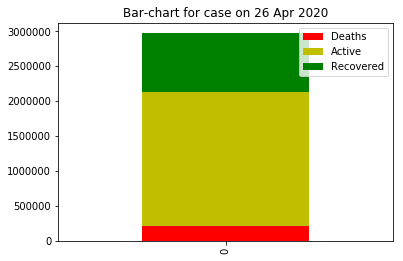

In [54]:
title = 'Bar-chart for case on ' + last_date.strftime("%d %b %Y")
df_last_date.groupby('Date').sum().reset_index()[['Deaths','Active','Recovered']].plot(kind='bar',stacked=True, title =title, color = ['r','y','g'] )

In [55]:
temp_df = df.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp_df = temp_df.melt(id_vars='Date', value_vars=['Deaths', 'Active','Recovered'],var_name='Case', value_name='Count')

fig = px.area(temp_df, x='Date', y='Count', color='Case', height=600,
             title='Cases over time', color_discrete_sequence = ['red', 'yellow', 'green'])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

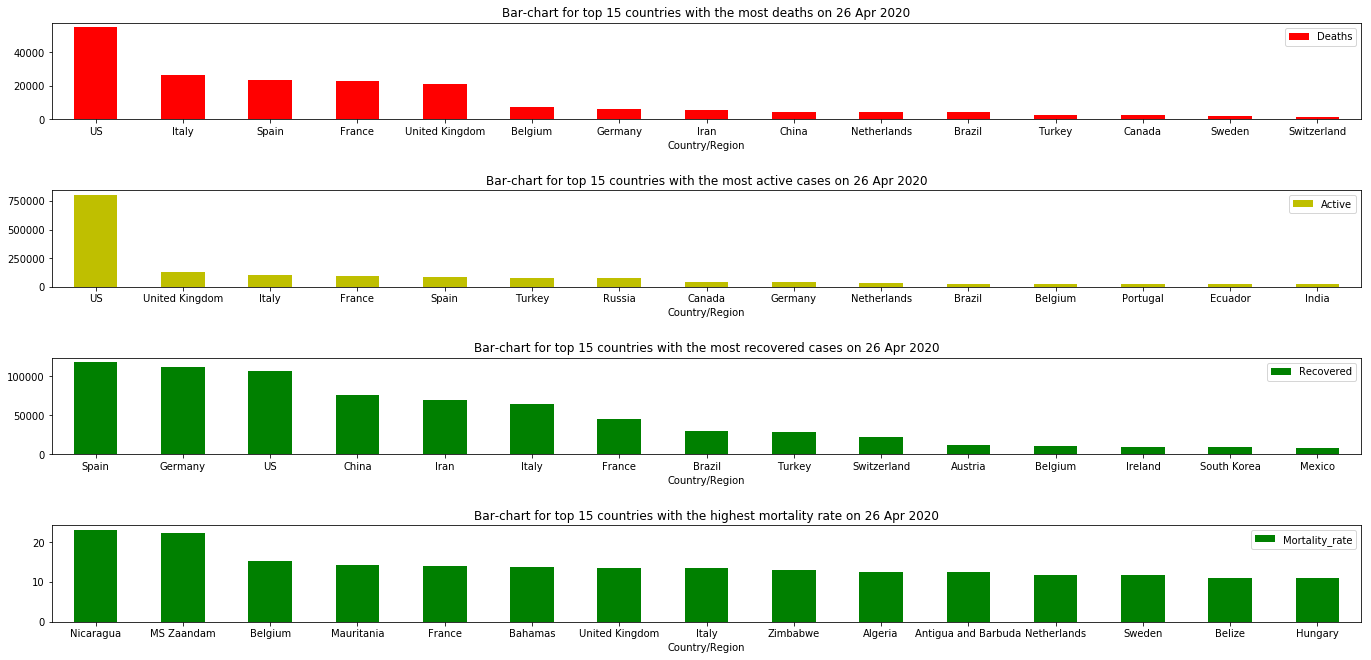

In [56]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
fig.tight_layout(pad = 5) 

df_country_last_date = df_date_country[df_date_country['Date'] == last_date]

#Creating the subplot for deaths.
title = 'Bar-chart for top 15 countries with the most deaths on ' + last_date.strftime("%d %b %Y")

temp_df = df_country_last_date.sort_values(by= ['Deaths'], ascending=False).set_index('Country/Region').head(15)

temp_df[['Deaths']].plot(kind='bar', title = title, color = ['r'], linewidth = 5,ax=axes[0],rot=0)

#Creating the subplot for active patients.
title = 'Bar-chart for top 15 countries with the most active cases on ' + last_date.strftime("%d %b %Y")

temp_df = df_country_last_date.sort_values(by= ['Active'], ascending=False).set_index('Country/Region').head(15)

temp_df[['Active']].plot(kind='bar', title = title, color = ['y'], linewidth = 5,ax=axes[1],rot=0)

#Creating the subplot for deaths.
title = 'Bar-chart for top 15 countries with the most recovered cases on ' + last_date.strftime("%d %b %Y")

temp_df = df_country_last_date.sort_values(by= ['Recovered'], ascending=False).set_index('Country/Region').head(15)

temp_df[['Recovered']].plot(kind='bar', title = title, color = ['g'], linewidth = 5,ax=axes[2],rot=0)

#Creating the subplot for mortality rate.
title = 'Bar-chart for top 15 countries with the highest mortality rate on ' + last_date.strftime("%d %b %Y")

temp_df = df_country_last_date.sort_values(by= ['Mortality_rate'], ascending=False).set_index('Country/Region').head(15)

temp_df[['Mortality_rate']].plot(kind='bar', title = title, color = ['g'], linewidth = 5,ax=axes[3],rot=0)

#### Mapping

First of all the information for the number of confirmed cases and the number of deaths is plotted on a map.

In [57]:
base_map = folium.Map(location=[0, 0], tiles= "cartodbpositron",min_zoom=2, zoom_start=2, max_zoom=3)
confirmed_mean = temp_df['Confirmed'].mean()

temp_df1 = df[df['Date']==last_date]

temp_df1.apply(lambda row:folium.CircleMarker(location=[row["Lat"], row["Long"]]
                                       ,fill='crimson'
                                       ,color='crimson'
                                       ,tooltip='<li><bold>Country : '+str(row['Country/Region'])+
                                                              '<li><bold>Province : '+str(row['Province/State'])+
                                                              '<li><bold>Confirmed : '+str(row['Confirmed'])+
                                                              '<li><bold>Deaths : '+str(row['Deaths'])
                                       ,radius = 2
                                      ).add_to(base_map)
                                              , axis=1)
base_map

Adding a heatmap on top of the above map with the number of confirmed cases.

In [58]:
# The heatmap function of folium cannot handle dataframes, so list of latitudes and longtitudes needs to be created.
confirmed_coord = [[row['Lat'], row['Long'],row['Confirmed']] for index, row in temp_df1.iterrows()]

#Add the Heatmap on the map
HeatMap(confirmed_coord, radius = 15).add_to(base_map)

#Display the map
base_map

Last part of the mapping part is the creation of a choropleth for the confirmed COVID-19 patients and another one for the average temperatures.

A choropleth map shows a change across a geographic landscape within enumeration units such as countries, states, or watersheds. A heat map shows a change across a geographic landscape as a rasterized dataset–conforming to an arbitrary, but usually small, grid size. 

As a result, the choropleth allows for an easier classification between the enumaration units, which in this case are countries.

In [67]:
fig = px.choropleth(df_last_date, 
                    locations="Country/Region", 
                    color="Confirmed", 
                    locationmode = 'country names', 
                    hover_name="Country/Region",
                    range_color=[0,330000],
                    title='Global COVID-19 Infections as of '+last_date.strftime("%d %b %Y"))
fig.show()

In [76]:
fig = px.choropleth(mean_temp, 
                    locations="Country", 
                    color="AverageTemperature", 
                    locationmode = 'country names', 
                    hover_name="Country",
                    range_color=[0,30],
                    title='Global Average Temperatures')
fig.show()

#### Effect of latitude on the COVID-19 spread

The analysis of the effect of latitude on the spread and mortality rate of the COVID-19 virus a number of 

In [61]:
df_global2 = df_last_date
df_global2 = df_global2.rename(columns={'Lat': 'Latitude', 'Long': 'Longitude'})
df_global2['Latitude'] = abs(df_global2['Latitude'])
df_global2 = df_global2[df_global2['Latitude'] < 70]
df_global2 = df_global2[df_global2['Country/Region']!='China']

fig = px.scatter(df_global2.sort_values('Deaths',ascending=False), 
             x="Latitude", 
             y="Confirmed",
             title='Global COVID-19 Infections vs Absolute Value of Latitude Coordinate as of '+last_date.strftime("%d %b %Y"))
fig.show()

fig = px.scatter(df_global2.sort_values('Deaths',ascending=False), 
             x="Latitude", 
             y="Deaths",
             title='Global COVID-19 Deaths vs Absolute Value of Latitude Coordinate as of '+last_date.strftime("%d %b %Y"))
fig.show()
fig = px.scatter(df_global2.sort_values('Deaths',ascending=False), 
             x="Latitude", 
             y="Mortality_rate",
             title='Global COVID-19 Mortality Rates vs Absolute Value of Latitude Coordinate as of '+last_date.strftime("%d %b %Y"))
fig.show()

In [64]:
df_mort_bars = df_last_date
df_mort_bars['Lat'] = abs(df_mort_bars['Lat'])
fig = px.bar(df_mort_bars[df_mort_bars['Lat'] < 90].sort_values('Mortality_rate',ascending=False)[0:20], 
             x="Lat", 
             y="Mortality_rate",
             title='Global COVID-19 Mortality Rates as of '+ last_date.strftime("%d %b %Y") +' for Countries with Top 20 Most Deaths')
fig.show()